### 🔬DIABETIC RETINOPATHY CLASSIFICATION using ResNet152V2🔬

### About Resnet152V2 Model

- ResNet152V2 Architecture: ResNet152V2 is a deep neural network with 152 layers, utilizing residual learning to address challenges in training very deep networks.

- Image Classification Excellence: Known for top-tier performance in image classification tasks, ResNet152V2 is often pre-trained on large datasets like ImageNet, enabling accurate predictions across diverse visual recognition challenges.

- Transfer Learning Advantage: ResNet152V2 is commonly used for transfer learning, leveraging its pre-trained weights to adapt to specific tasks with limited labeled data, making it a valuable tool for various computer vision applications.

### Description of the dataset 📝

- This dataset is designed for the task of Diabetic Retinopathy Classification using Convolutional Neural Networks (CNN). The dataset comprises two main sets: training and testing. The training set consists of images categorized into five distinct classes denoted by labels 0, 1, 2, 3, and 4, each representing different stages or severity levels of diabetic retinopathy.

- The training set is organized into five folders, each corresponding to one of the five classes. Similarly, the testing set follows the same structure with images of retinas for evaluation.

### Our goal 🎯

- Goal is clear and simple. The primary goal of this project is to train a CNN model to accurately classify diabetic retinopathy severity levels based on the provided image data.

### Importing Libraries 📚

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import cv2


### Splitting data 📃✂️

In [3]:
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

data_folder = '/content/drive/MyDrive/DR_data_cropped_classes/DR_data_cropped_classes/train'
train_folder = '/content/train'
test_folder = '/content/test'
test_size = 0.2  # 20% of the data will be used for testing

# Loop through each class folder
for i in os.listdir(data_folder):
    class_path = os.path.join(data_folder, i)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # Get a list of all the images in the class folder
        images = os.listdir(class_path)

        # Use train_test_split to split the images into train and test sets
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        # Create folders for train and test data if they don't exist
        train_class_path = os.path.join(train_folder, i)
        test_class_path = os.path.join(test_folder, i)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Copy images to train folder
        for img_name in train_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(train_class_path, img_name)
            copyfile(src, dst)

        # Copy images to test folder
        for img_name in test_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(test_class_path, img_name)
            copyfile(src, dst)


### 🧭 Exploring the data 🧭

#### Loading data

In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# Hyperparameters
learning_rate = 0.0001
batch_size = 32

train_path = '/content/train'
valid_path = '/content/test'

In [7]:
# useful for getting number of output classes
folders = glob('/content/train/*')
folders

['/content/train/0',
 '/content/train/1',
 '/content/train/3',
 '/content/train/2',
 '/content/train/4']

In [8]:
# check the number of images in each class in the training dataset

No_images_per_class = []
class_name = []
for i in os.listdir('/content/train'):
    train_class = os.listdir(os.path.join('train', i))
    No_images_per_class.append(len(train_class))
    class_name.append(i)
    print('Number of images in {}   {} \n'.format(i, len(train_class)))


Number of images in 0   720 

Number of images in 1   720 

Number of images in 3   617 

Number of images in 2   720 

Number of images in 4   486 



In [9]:
# check the number of images in each class in the testing dataset
No_images_per_class = []
class_name = []
for i in os.listdir('/content/test'):
    train_class = os.listdir(os.path.join('test', i))
    No_images_per_class.append(len(train_class))
    class_name.append(i)
    print('Number of images in {}   {} \n'.format(i, len(train_class)))

Number of images in 0   180 

Number of images in 1   180 

Number of images in 3   155 

Number of images in 2   180 

Number of images in 4   122 



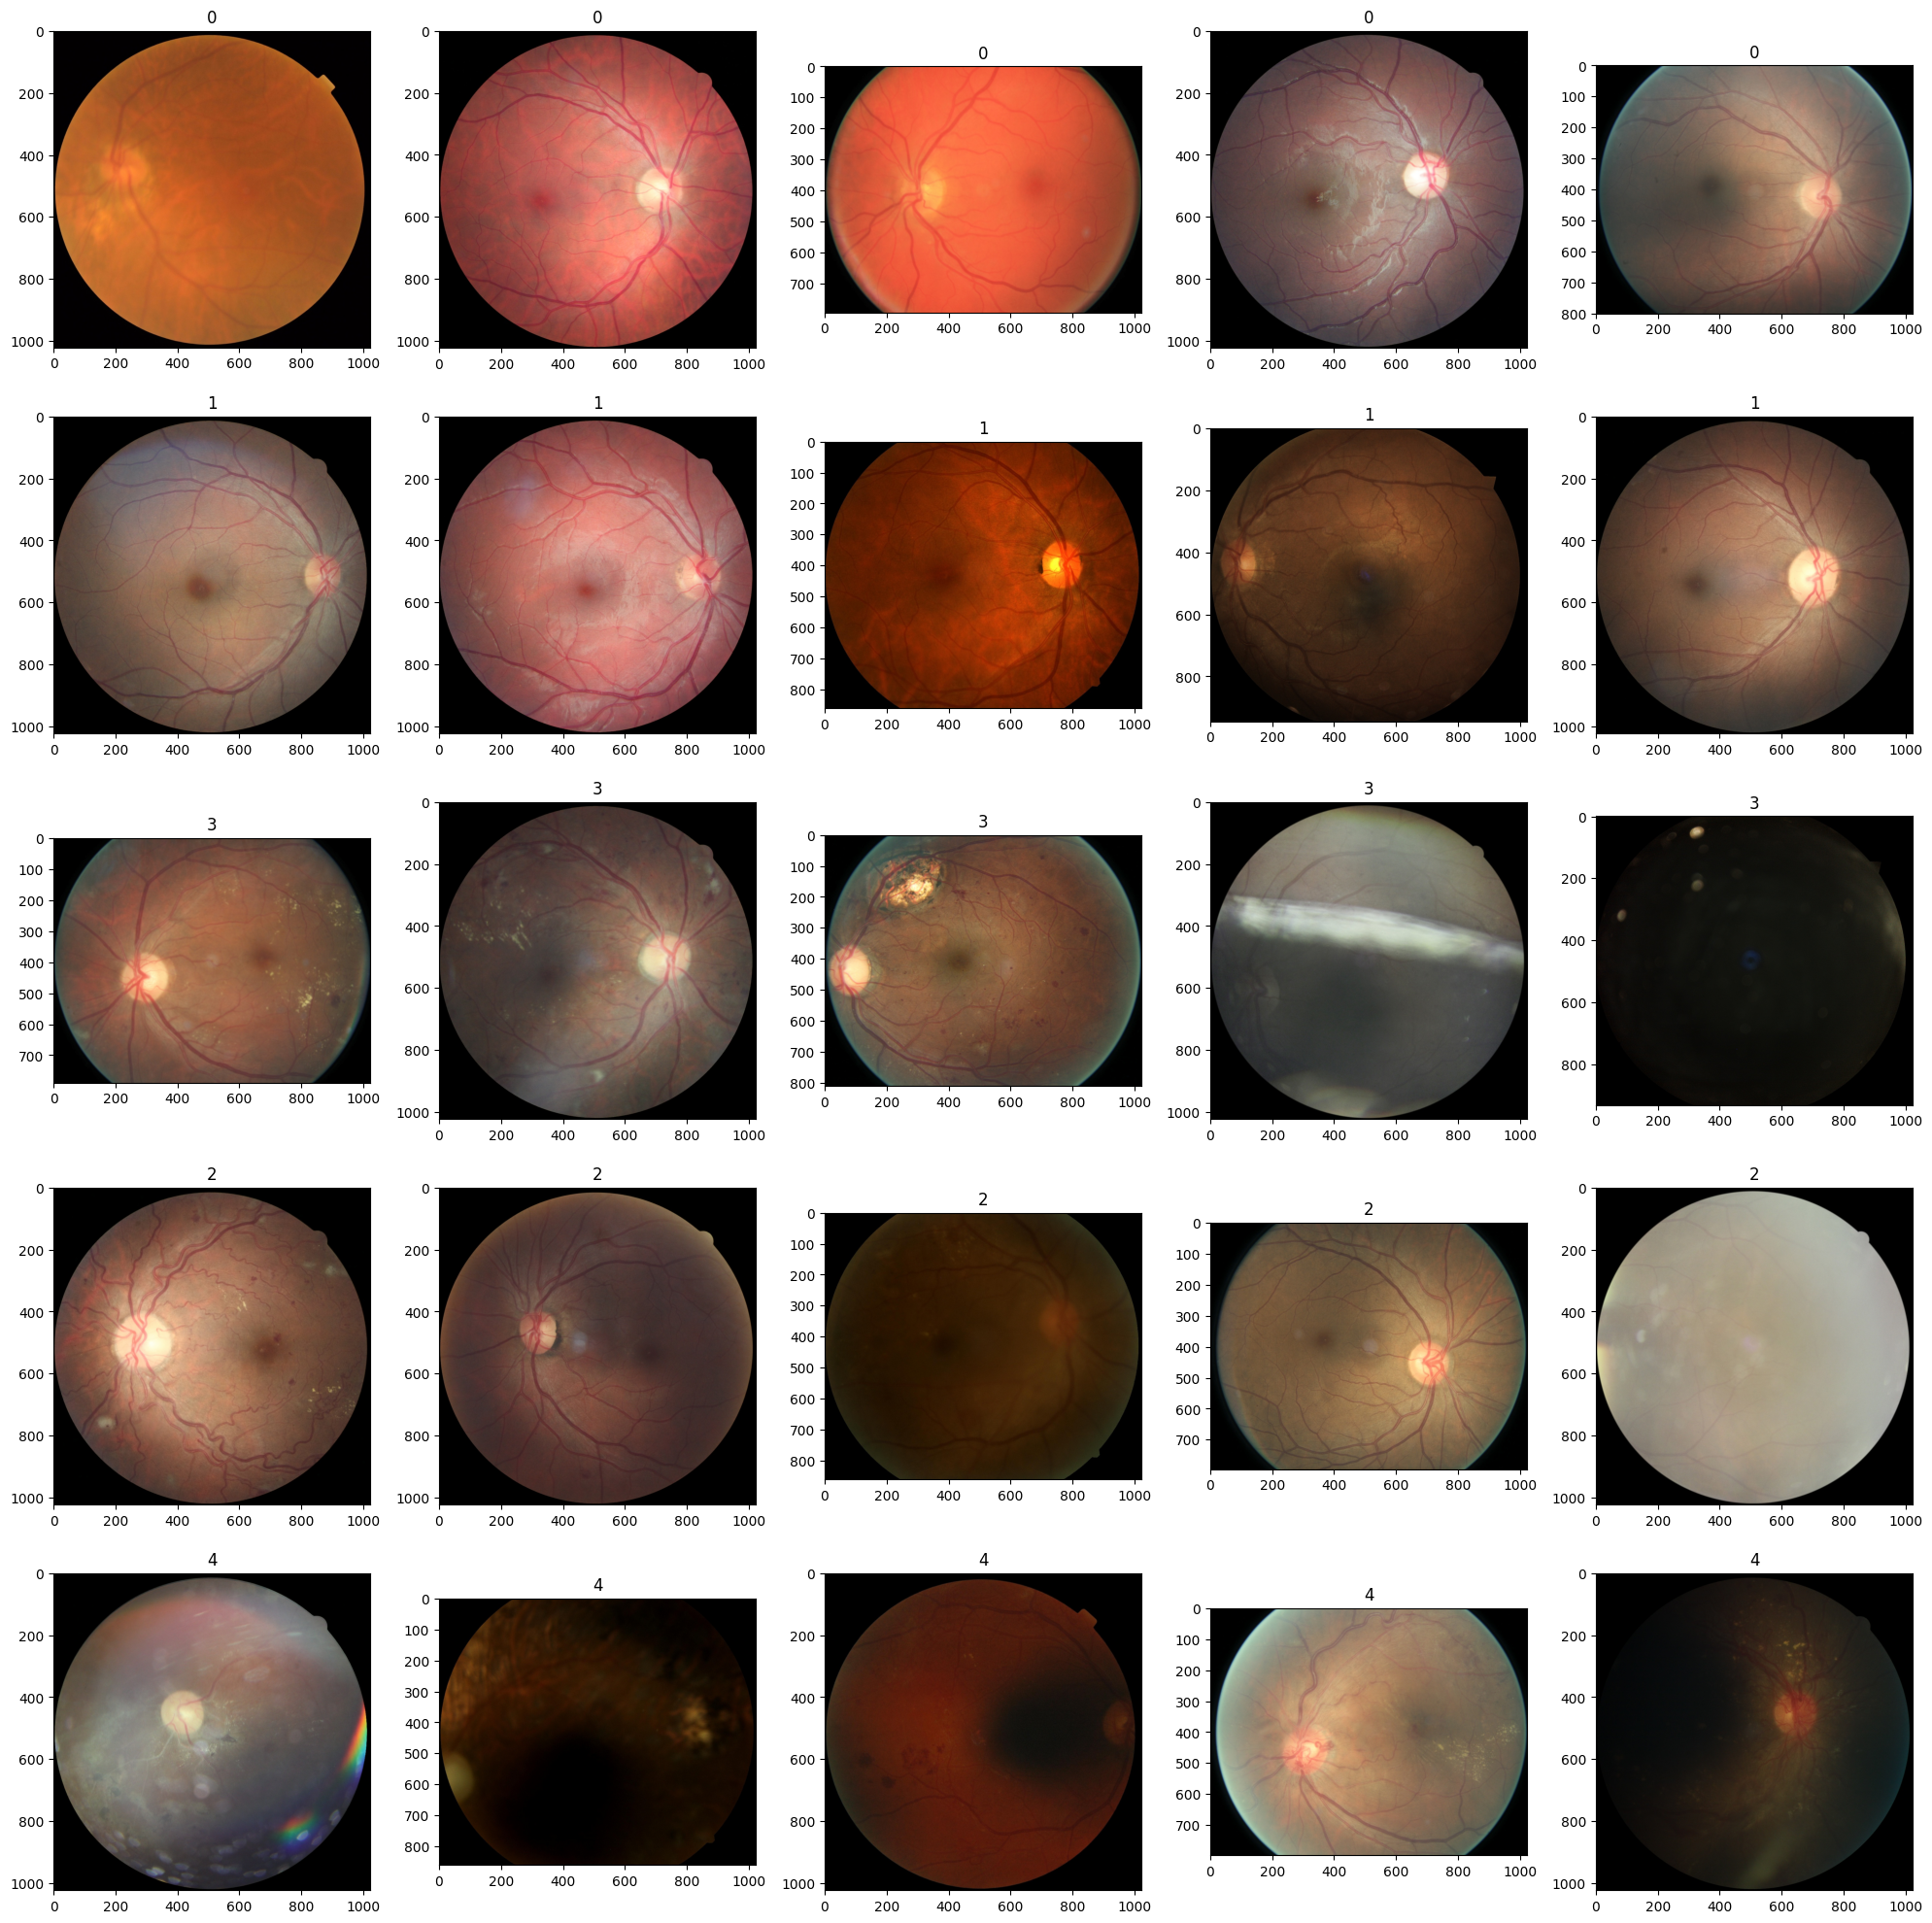

In [10]:
# Visualize 5 images of each class in the dataset
import PIL
fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in os.listdir('/content/train'):
    # get the list of images in a given class
    train_class = os.listdir(os.path.join('train', i))
    # plot 5 images per class
    for j in range(5):
        img = os.path.join('train', i, train_class[j])
        img = PIL.Image.open(img)
        axs[count][j].title.set_text(i)
        axs[count][j].imshow(img)
    count += 1

fig.tight_layout()

### 🏗️ Model Building 🏗️

In [12]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
import tensorflow
resnet152V2 =tensorflow.keras.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


# Build the model
base_model = ResNet152V2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
output = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()



234545216/234545216 [==============================] - 9s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                           

### Data Augmentation 📊

In [14]:
# Image Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')

Found 3263 images belonging to 5 classes.
Found 817 images belonging to 5 classes.


### 🏋️ Training the model 🏋️

In [26]:
# Training the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=12,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
)

<ipython-input-26-e25074b2d175>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/12
102/102 [==============================] - 52s 511ms/step - loss: 0.6759 - accuracy: 0.7380 - val_loss: 1.8063 - val_accuracy: 0.4198
Epoch 2/12
102/102 [==============================] - 51s 503ms/step - loss: 0.6548 - accuracy: 0.7499 - val_loss: 1.8735 - val_accuracy: 0.4002
Epoch 3/12
102/102 [==============================] - 52s 506ms/step - loss: 0.6516 - accuracy: 0.7551 - val_loss: 1.9603 - val_accuracy: 0.3941
Epoch 4/12
102/102 [==============================] - 52s 505ms/step - loss: 0.6187 - accuracy: 0.7656 - val_loss: 1.9058 - val_accuracy: 0.3929
Epoch 5/12
102/102 [==============================] - 51s 501ms/step - loss: 0.6627 - accuracy: 0.7401 - val_loss: 2.0426 - val_accuracy: 0.4027
Epoch 6/12
102/102 [==============================] - 53s 515ms/step - loss: 0.5741 - accuracy: 0.7744 - val_loss: 1.8996 - val_accuracy: 0.4100
Epoch 7/12
102/102 [==============================] - 51s 501ms/step - loss: 0.5758 - accuracy: 0.7833 - val_loss: 2.0978 - val_ac

### 📈 Plotting 📈

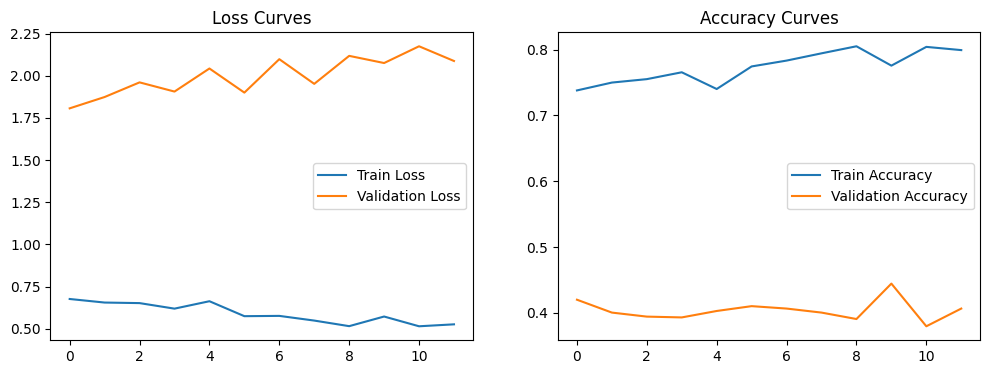

In [27]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

### 🧪 Testing model on test data 🧪

In [30]:
# Evaluate the model
test_results = model.evaluate(test_set)
print(f"Test Accuracy: {test_results[1]}")

# Confusion matrix and classification report
predictions = model.predict(test_set)
y_true = np.argmax(test_set.classes)
y_pred = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix, classification_report

# Assuming test_set is a generator and has the attribute classes
# If not, replace it with the true labels for your test set
y_true = np.array(test_set.classes)

# Assuming predictions is a one-hot encoded array, you need to convert it to class labels
y_pred = np.argmax(predictions, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))



26/26 [==============================] - 5s 187ms/step - loss: 2.0871 - accuracy: 0.4064
Test Accuracy: 0.4063647389411926
26/26 [==============================] - 5s 183ms/step
Confusion Matrix:
[[55 43 20 50 12]
 [59 42 26 38 15]
 [57 41 28 42 12]
 [55 36 23 33  8]
 [32 32 11 31 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.31      0.25       180
           1       0.22      0.23      0.22       180
           2       0.26      0.16      0.19       180
           3       0.17      0.21      0.19       155
           4       0.25      0.13      0.17       122

    accuracy                           0.21       817
   macro avg       0.22      0.21      0.21       817
weighted avg       0.22      0.21      0.21       817



### Attention map

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 73.5MB/s]


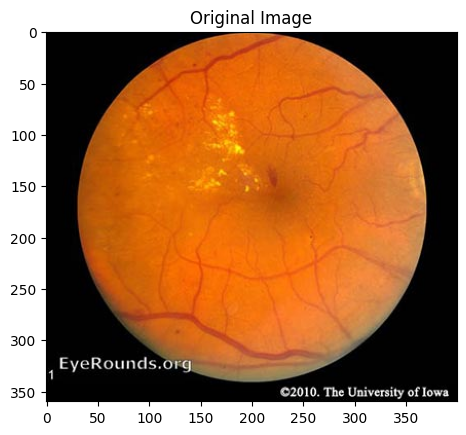

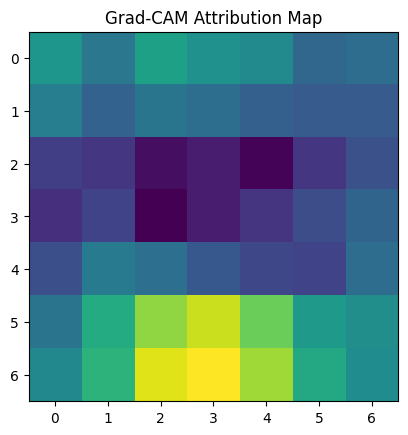

In [31]:
!pip install captum
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
# Load the pre-trained ResNet-152V2 model
model = models.resnet152(pretrained=True)
model.eval()

# Define the image preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the input image
image_path = '/content/NPDR.jpg'
img = Image.open(image_path)
img_tensor = preprocess(img)
img_tensor = Variable(img_tensor.unsqueeze(0))

# Define the Grad-CAM attribution method
layer_grad_cam = LayerGradCam(model, model.layer4[2].conv3)  # Adjust the layer as needed

# Perform Grad-CAM attribution
attr_map = layer_grad_cam.attribute(img_tensor, target=0)  # Specify the target class (you can change this)

# Normalize the attribution map
attr_map = (attr_map - attr_map.min()) / (attr_map.max() - attr_map.min())

# Display the original image
plt.imshow(img)
plt.title('Original Image')
plt.show()

# Display the Grad-CAM attribution map
plt.imshow(attr_map[0].squeeze().detach().numpy(), cmap='viridis')
plt.title('Grad-CAM Attribution Map')
plt.show()
